In [1]:
import h5py
import torch
import sys
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
sys.path.append('../scripts/src')
from admixture_ae import AdmixtureAE
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=False, reverse=False, legend=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color, width=1))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)
    plt.yticks([])
    plt.xticks([])
    if legend:
        plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

    if grid:
        plt.grid()
    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")
    plt.xlim((0, data.shape[1]))

In [42]:
window_size = '1K'
tr_filename = f'/mnt/gpid07/users/margarita.geleta/data/chr22/prepared/train{window_size}.h5'
val_filename = f'/mnt/gpid07/users/margarita.geleta/data/chr22/prepared/valid{window_size}.h5'
tr_data = h5py.File(tr_filename, 'r')
val_data = h5py.File(val_filename, 'r')
X, y = tr_data['snps'], tr_data['populations']
valX, valY = val_data['snps'], val_data['populations']
ancestries, labels_train = np.unique(y, return_inverse=True)

In [3]:
datafile = '../data/all_chm_combined_snps_world_2M_with_labels.npz'
npzfile = np.load(datafile, allow_pickle=True)
loaded_file = npzfile['snps']

In [4]:
num_features = 0
dataset = loaded_file if num_features <= 0 else loaded_file[:,:num_features]
labels_train_names = npzfile['populations']
ancestries, labels_train = np.unique(labels_train_names, return_inverse=True)
#del labels_train_names, npzfile

X, valX, y, valY = train_test_split(dataset, labels_train, test_size=.15, random_state=42)

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
valX_pca = pca.transform(valX)

In [22]:
batch_size = 200
loss = 'bce'
frac = 0.1
k = 7
lambda_l0 = 0.0
deep_encoder = True
init = 'mean_random'
MODELS_PATH = '../outputs'
encoder_type = 'Deep' if deep_encoder else 'Shallow'
MODEL_NAME = f'{encoder_type}_Windowed_{window_size}_init_{init}_K_{k}_lambdal0_{lambda_l0}_{loss}_frac_{frac}_BS_{batch_size}.pt'
# MODEL_NAME = f'Shallow_Windowed_50000_init_kmeans_logit_K_7_lambdal0_0.0_bce_frac_1.0_BS_400.pt'

In [23]:
ADM = AdmixtureAE(k, X.shape[1], lambda_l0=lambda_l0, deep_encoder=deep_encoder)
ADM.load_state_dict(torch.load(f'{MODELS_PATH}/{MODEL_NAME}', map_location=torch.device('cpu')))

INFO:admixture_ae:Random decoder initialization.


<All keys matched successfully>

NameError: name 'ancestries' is not defined

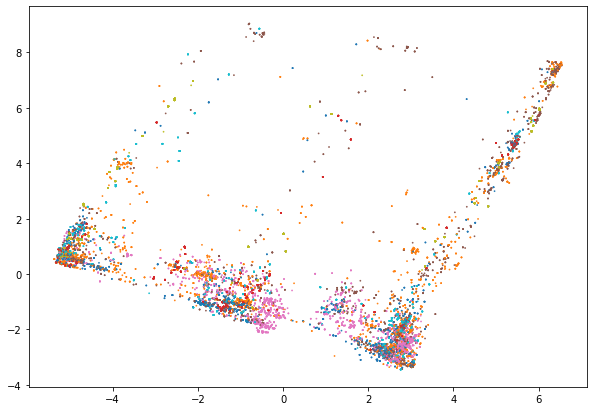

In [24]:
P = torch.sigmoid(list(ADM.parameters())[-1]).detach().numpy()
C = pca.transform(P)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=0.6, alpha=0.9, cmap="tab10") #label=y, 
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*(scatter.legend_elements()[0], ancestries), title="Classes")

ax.add_artist(legend1)

n = [str(i) for i in range(k)]
for i, txt in enumerate(n):
    ax.annotate(txt, (C[i,0], C[i,1]), fontsize='large')

    plt.title(f'{loss}, {num_features} SNPs')
plt.show()

In [30]:
with torch.no_grad():
    tr_output = ADM(torch.tensor(X).float())[1]
    val_output = ADM(torch.tensor(valX).float())[1]

In [31]:
tr_output

tensor([[1.1477e-03, 9.9874e-01, 2.9085e-05,  ..., 8.3432e-08, 4.1881e-05,
         3.8007e-05],
        [2.6013e-02, 9.4947e-04, 5.9166e-01,  ..., 8.5093e-04, 3.8023e-01,
         2.9049e-04],
        [1.6421e-08, 6.6979e-03, 4.0717e-06,  ..., 9.0296e-04, 4.3359e-07,
         5.5283e-01],
        ...,
        [9.9525e-01, 6.4954e-05, 4.2868e-03,  ..., 6.2075e-08, 3.6250e-04,
         2.5477e-06],
        [2.1056e-08, 1.6961e-06, 9.9942e-01,  ..., 3.3480e-04, 1.9217e-07,
         2.1548e-07],
        [6.1238e-04, 1.5521e-03, 9.9492e-01,  ..., 7.7207e-06, 2.3518e-03,
         2.7333e-04]])

In [ ]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0, hspace=0)
for k_idx in range(k):
    if k_idx == 0:
        ax1 = plt.subplot(1,k,k_idx+1)
    else:
        plt.subplot(1,k,k_idx+1, sharey=ax1)
    labels_plot = [str(i) for i in range(k)]
    plot_stacked_bar(tr_output.detach().T[:, np.array(y) == k_idx], labels_plot, legend=k_idx == k-1)
    plt.title(ancestries[k_idx])

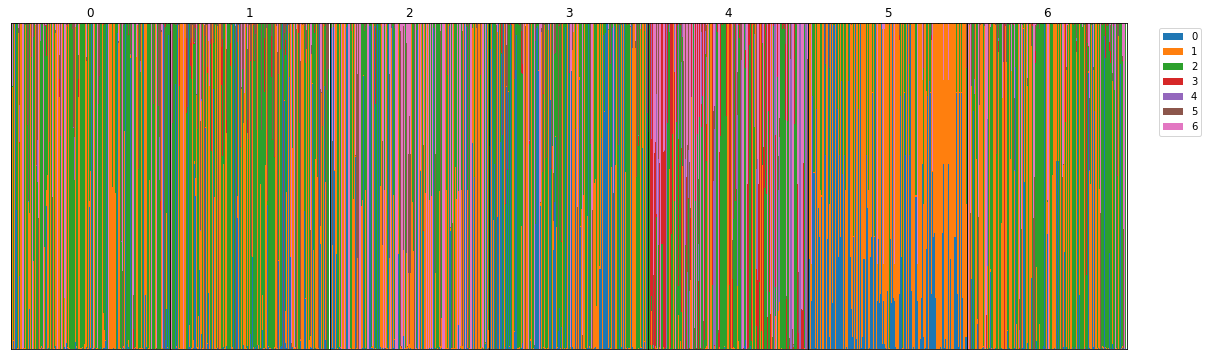

In [44]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0, hspace=0)
for k_idx in range(k):
    if k_idx == 0:
        ax1 = plt.subplot(1,k,k_idx+1)
    else:
        plt.subplot(1,k,k_idx+1, sharey=ax1)
    labels_plot = [str(i) for i in range(k)]
    plot_stacked_bar(val_output.detach().T[:, np.array(valY) == k_idx], labels_plot, legend=k_idx == k-1)
    plt.title(ancestries[k_idx])

In [46]:
k_means_obj = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=42).fit(X)

In [47]:
P_init = torch.tensor(k_means_obj.cluster_centers_).float()
P_init_logit = torch.logit(P_init, eps=1e-8)

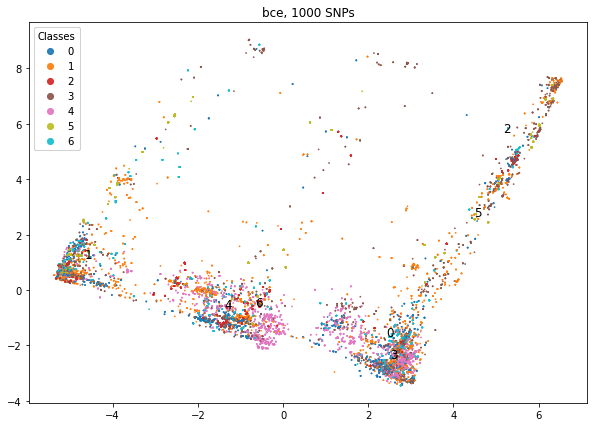

In [48]:
C_init = pca.transform(P_init)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=0.6, alpha=0.9, cmap="tab10") #label=y, 
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*(scatter.legend_elements()[0], ancestries), title="Classes")

ax.add_artist(legend1)

n = [str(i) for i in range(k)]
for i, txt in enumerate(n):
    #ax.annotate(txt, (C[i,0], C[i,1]), fontsize='large')
    ax.annotate(txt, (C_init[i,0], C_init[i,1]), fontsize='large')
    plt.title(f'{loss}, {num_features} SNPs')
    plt.title(f'{loss}, {num_features} SNPs')
plt.show()